In [111]:
# Install additional packages if needed
!pip install scikit-learn pandas numpy matplotlib seaborn plotly

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [112]:
# Load the dataset
df = pd.read_csv('data_YesBank_StockPrices.csv')

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\n First 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nStatistical Summary:")
print(df.describe())

Dataset Shape: (185, 5)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB
None

 First 5 rows:
     Date   Open   High    Low  Close
0  Jul-05  13.00  14.00  11.25  12.46
1  Aug-05  12.58  14.88  12.55  13.42
2  Sep-05  13.48  14.87  12.27  13.30
3  Oct-05  13.20  14.47  12.40  12.99
4  Nov-05  13.35  13.88  12.88  13.41

Last 5 rows:
       Date   Open   High    Low  Close
180  Jul-20  25.60  28.30  11.10  11.95
181  Aug-20  12.00  17.16  11.85  14.37
182  Sep-20  14.30  15.34  12.75  13.15
183  Oct-20  13.30  14.01  12.11  12.42
184  Nov-20  12.41  14.90  12.21  14.67

Statistical Summary:
             Open    

In [113]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

# Extract date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print("Date processing completed!")
print(df[['Date', 'Year', 'Month', 'Quarter']].head())

Date processing completed!
        Date  Year  Month  Quarter
0 2005-07-01  2005      7        3
1 2005-08-01  2005      8        3
2 2005-09-01  2005      9        3
3 2005-10-01  2005     10        4
4 2005-11-01  2005     11        4


In [114]:
# Technical indicators
df['Price_Range'] = df['High'] - df['Low']
df['Price_Change'] = df['Close'] - df['Open']
df['Price_Change_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100

# Moving averages (lagged features)
df['MA_3'] = df['Close'].rolling(window=3).mean()     #short-term
df['MA_6'] = df['Close'].rolling(window=6).mean()     #medium-term
df['MA_12'] = df['Close'].rolling(window=12).mean()   #long-term

# Volatility (rolling standard deviation) ---> measures standard deviation in the closing prices.
#Indicates the uncertainity. higher volatality means more unpredicatble behavior.
df['Volatility_3'] = df['Close'].rolling(window=3).std()
df['Volatility_6'] = df['Close'].rolling(window=6).std()

# Lagged features (previous month's values)---->adds memory to the model,helps in learning patterns
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)

# Relative position in price range
df['Position_in_Range'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

print("✅ Feature engineering completed!")
print(f"New dataset shape: {df.shape}")

✅ Feature engineering completed!
New dataset shape: (185, 20)


In [115]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())   #checks if missing values are there and adds up how many missing values
                           #in each coulumn

# Remove rows with NaN values and re-numbers rows
df_clean = df.dropna().reset_index(drop=True)
print(f"\nClean dataset shape: {df_clean.shape}")

Missing values:
Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Year                  0
Month                 0
Quarter               0
Price_Range           0
Price_Change          0
Price_Change_Pct      0
MA_3                  2
MA_6                  5
MA_12                11
Volatility_3          2
Volatility_6          5
Close_Lag1            1
Close_Lag2            2
Close_Lag3            3
Position_in_Range     0
dtype: int64

Clean dataset shape: (174, 20)


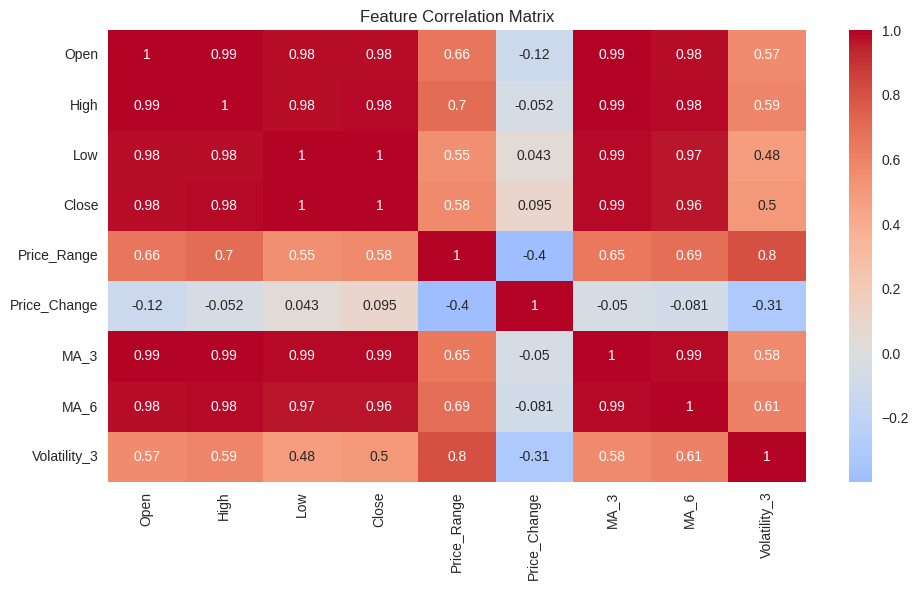

In [116]:
# set-up for subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Stock Price Over Time', 'Volume Analysis',
                   'Price Distribution', 'Correlation Heatmap'),
    specs=[[{"secondary_y": True}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Stock price over time
fig.add_trace(
    go.Scatter(x=df_clean['Date'], y=df_clean['Close'],
              name='Close Price', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df_clean['Date'], y=df_clean['MA_12'],
              name='12-Month MA', line=dict(color='red')),
    row=1, col=1
)
# shows how stock price change over time
#INSIGHTS
      # If the price is above the red line → the stock is doing well.
      # If the price falls below the red line → the stock may be going down.
#Business Impact
      # positive business impact-->good for investors to decide when to buy or sell and
      #Helps the company or analysts understand if the stock is growing steadily.


###########################################################################################


# Price range analysis
fig.add_trace(
    go.Scatter(x=df_clean['Date'], y=df_clean['Price_Range'],
              name='Price Range', line=dict(color='green')),
    row=1, col=2
)
#It shows how much the price jumps or drops in one day, called volatality.
#INSIGHTS:
      #Big ups and downs mean the stock is very risky.
      #Small changes mean the stock is more stable.
#Business imapct:
    #Helps in deciding risk.
    #Investors can be more careful when the stock is too jumpy.



###########################################################################################




# Price distribution
fig.add_trace(
    go.Histogram(x=df_clean['Close'], name='Price Distribution',
                nbinsx=30, marker_color='purple'),
    row=2, col=1
)

fig.update_layout(height=800, title_text="Yes Bank Stock Analysis")
fig.show()

# It shows how often the stock closed at different prices.
# INSIGHTS:
      # Shows the price range where the stock stays most of the time.
      # Helps to find common price levels.
# Business impact:
      # Helps set good buy or sell prices.
      # Shows if the stock price is mostly high or low.



######################################################################################

# Correlation analysis
plt.figure(figsize=(10, 6))
correlation_cols = ['Open', 'High', 'Low', 'Close', 'Price_Range',
                   'Price_Change', 'MA_3', 'MA_6', 'Volatility_3']
corr_matrix = df_clean[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# It shows how different features are related to each other.
# INSIGHTS:
    # Strong relationships mean some features move together.
    # Weak ones may not help in predictions.
# Business impact:
    # Helps in building better machine learning models.
    # Removes extra or useless data for faster training.


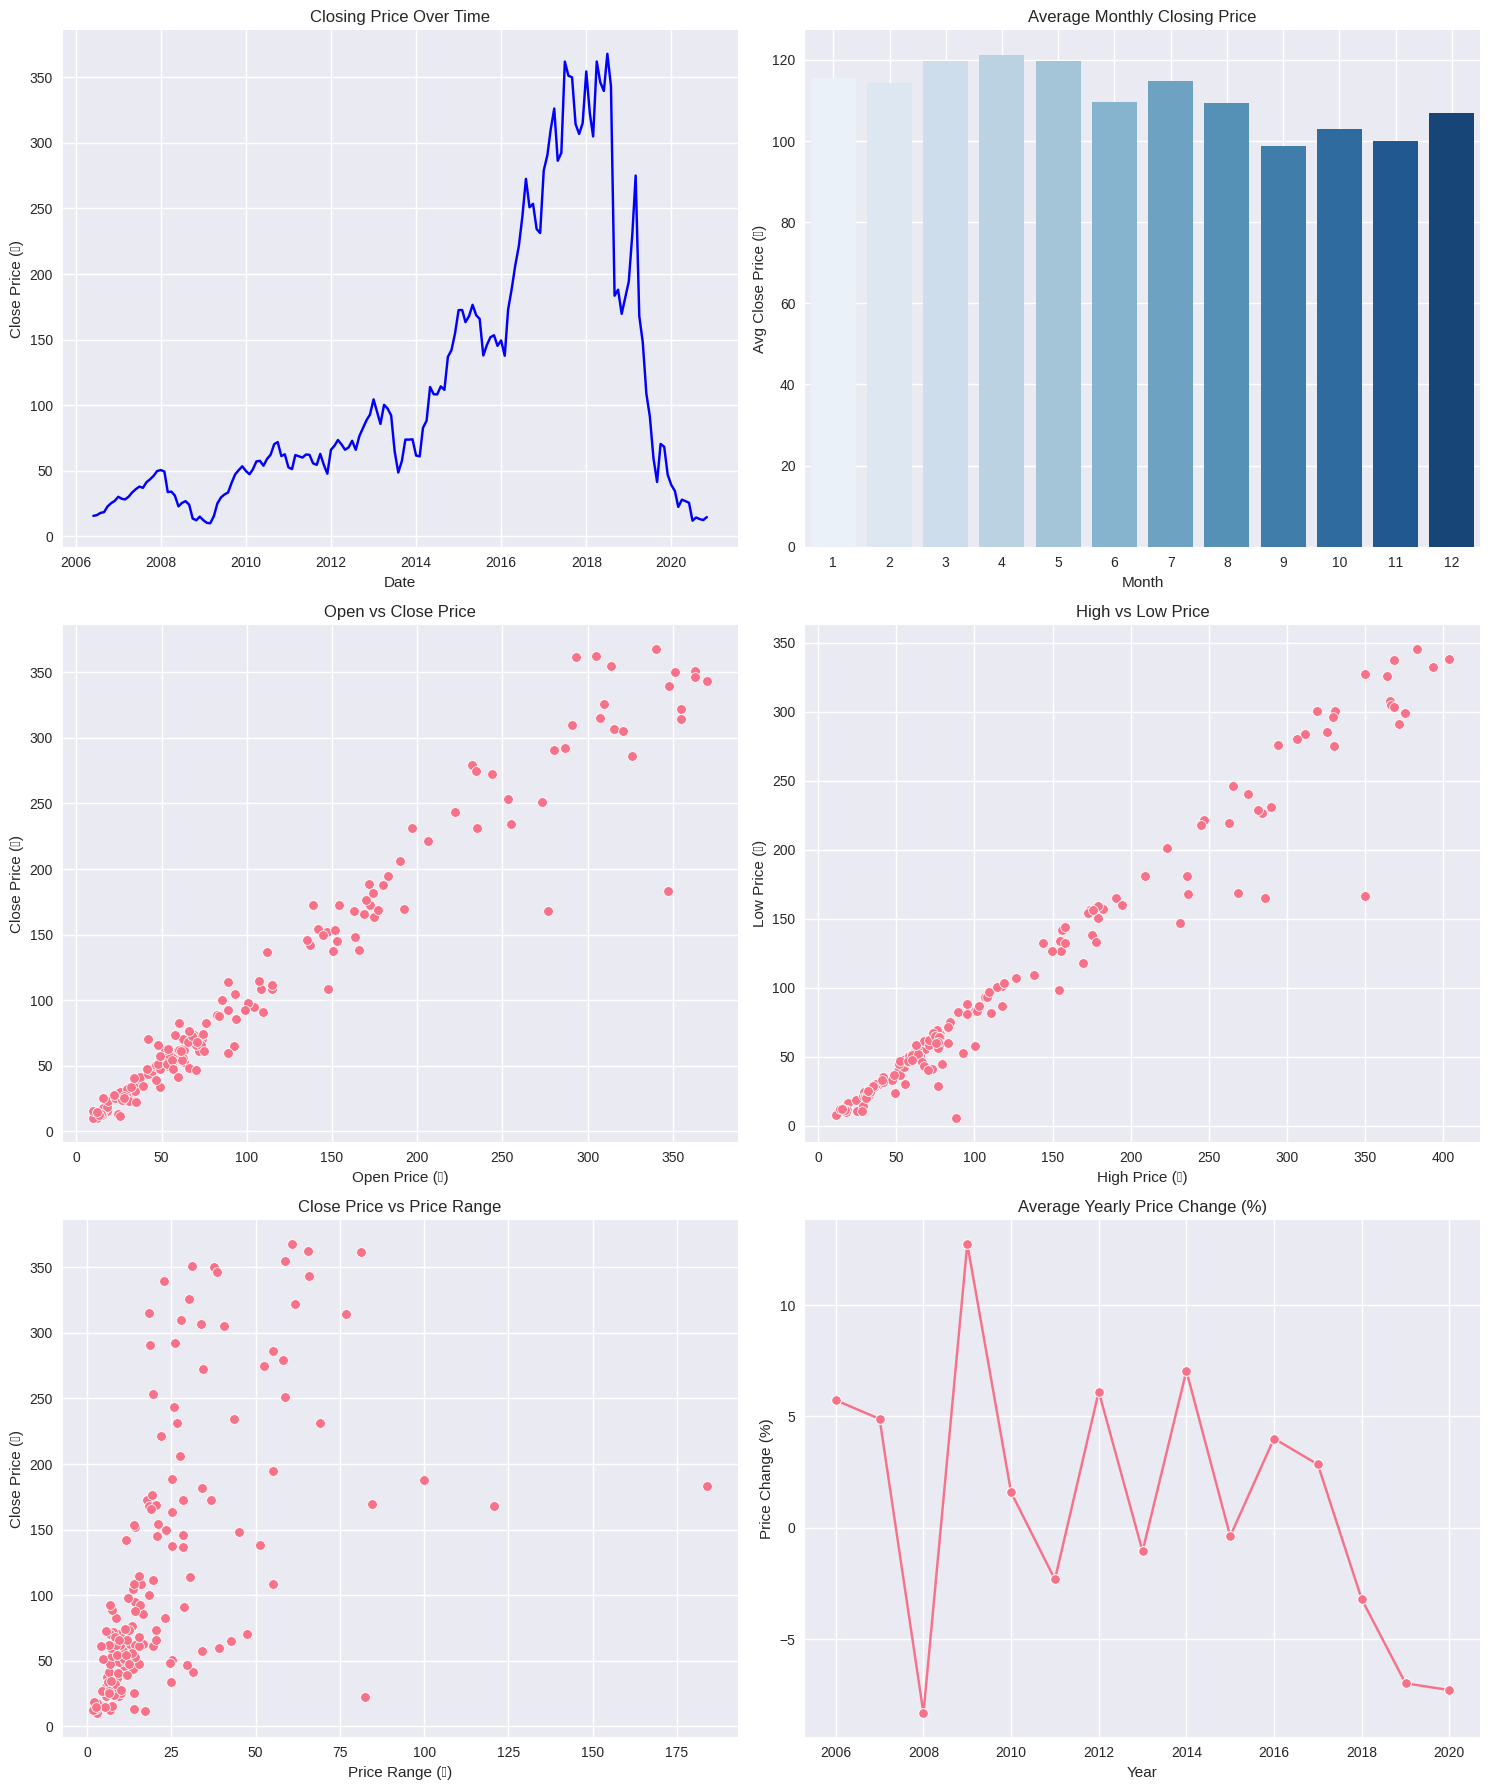

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create 3x2 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

#Closing Price Over Time
axes[0, 0].plot(df_clean['Date'], df_clean['Close'], color='blue')
axes[0, 0].set_title('Closing Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Close Price (₹)')
axes[0, 0].grid(True)


# It shows how the stock closed every day over time.

# INSIGHTS:
# Helps track the up and down movement of the stock.
# Shows if the stock is trending upward or downward.

# Business impact:
# Useful for understanding stock performance.
# Helps investors know if it's a good time to invest or sell.


###############################################################################################


#Monthly Average Close Price
monthly_avg = df_clean.groupby('Month')['Close'].mean().reset_index()
sns.barplot(data=monthly_avg, x='Month', y='Close', palette='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Average Monthly Closing Price')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Avg Close Price (₹)')
axes[0, 1].grid(True)

# It shows the average closing price for each month.

# INSIGHTS:
# Tells which months have higher or lower average prices.
# Can reveal seasonal patterns or stable months.

# Business impact:
# Helps plan marketing or investment around high/low months.
# Useful for timing trades during good months.


##################################################################################################

#Open vs Close
sns.scatterplot(x='Open', y='Close', data=df_clean, ax=axes[1, 0])
axes[1, 0].set_title('Open vs Close Price')
axes[1, 0].set_xlabel('Open Price (₹)')
axes[1, 0].set_ylabel('Close Price (₹)')
axes[1, 0].grid(True)

# It shows the relationship between the opening and closing price.

# INSIGHTS:
# If points are close to a straight line, the price didn’t change much.
# Far apart means price changed a lot during the day.

# Business impact:
# Helps understand daily price movement and volatility.
# Useful for day traders and short-term investors.


###############################################################################################

#High vs Low
sns.scatterplot(x='High', y='Low', data=df_clean, ax=axes[1, 1])
axes[1, 1].set_title('High vs Low Price')
axes[1, 1].set_xlabel('High Price (₹)')
axes[1, 1].set_ylabel('Low Price (₹)')
axes[1, 1].grid(True)


# It shows the highest and lowest prices of the day.

# INSIGHTS:
# Points close to the line = stable days.
# Points spread far = volatile days.

# Business impact:
# Helps assess risk in daily trading.
# High volatility can be both an opportunity and a threat.


##############################################################################################3

#Close vs Price Range
sns.scatterplot(x='Price_Range', y='Close', data=df_clean, ax=axes[2, 0])
axes[2, 0].set_title('Close Price vs Price Range')
axes[2, 0].set_xlabel('Price Range (₹)')
axes[2, 0].set_ylabel('Close Price (₹)')
axes[2, 0].grid(True)

# It shows how closing price changes with daily price range.

# INSIGHTS:
# A wide range with high close might mean strong demand.
# A wide range with low close might mean selling pressure.

# Business impact:
# Helps in spotting strong or weak market behavior.
# Useful for adjusting trading strategy based on price strength.


#############################################################################################


#Yearly Avg % Price Change
yearly_pct = df_clean.groupby('Year')['Price_Change_Pct'].mean().reset_index()
sns.lineplot(data=yearly_pct, x='Year', y='Price_Change_Pct', marker='o', ax=axes[2, 1])
axes[2, 1].set_title('Average Yearly Price Change (%)')
axes[2, 1].set_xlabel('Year')
axes[2, 1].set_ylabel('Price Change (%)')
axes[2, 1].grid(True)

# It shows the average percentage change in price for each year.

# INSIGHTS:
# Positive values = growth years.
# Negative values = decline years.

# Business impact:
# Shows long-term stock performance.
# Helps investors know which years were good or bad for the stock.


###############################################################################################


# Show all
plt.tight_layout()
plt.show()


In [118]:
# Key statistics
print("KEY STATISTICS")
print("="*50)
print(f"Highest Close Price: ₹{df_clean['Close'].max():.2f}")
print(f"Lowest Close Price: ₹{df_clean['Close'].min():.2f}")
print(f"Average Close Price: ₹{df_clean['Close'].mean():.2f}")
print(f"Price Range: ₹{df_clean['Close'].max() - df_clean['Close'].min():.2f}")
print(f" Total Trading Months: {len(df_clean)}")

KEY STATISTICS
Highest Close Price: ₹367.90
Lowest Close Price: ₹9.98
Average Close Price: ₹110.89
Price Range: ₹357.92
 Total Trading Months: 174


In [119]:
# Select features for modeling
feature_columns = [
    'Open', 'High', 'Low',                   #list of input colums to predict stock price
    'Price_Range', 'Close_Lag1',
    'Year', 'Month', 'Quarter'
]

# Prepare features and target
X = df_clean[feature_columns]      #table with input coumns
y = df_clean['Close']               #target variable-closing price

print("Features selected:")
print(feature_columns)
print(f"\n Feature matrix shape: {X.shape}")     #no of rows and columns
print(f" Target vector shape: {y.shape}")         #only rows, equal to rows in X

Features selected:
['Open', 'High', 'Low', 'Price_Range', 'Close_Lag1', 'Year', 'Month', 'Quarter']

 Feature matrix shape: (174, 8)
 Target vector shape: (174,)


In [120]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Don't shuffle for time series
)                     #20% test set,80% training set

print(" DATA SPLIT SUMMARY")
print("="*40)
print(f"Training set: {X_train.shape[0]} samples")    #no of rows in training
print(f"Test set: {X_test.shape[0]} samples")         #no of rows in test
print(f"Training period: {df_clean.iloc[X_train.index[0]]['Date'].strftime('%b-%Y')} to {df_clean.iloc[X_train.index[-1]]['Date'].strftime('%b-%Y')}")
print(f"Test period: {df_clean.iloc[X_test.index[0]]['Date'].strftime('%b-%Y')} to {df_clean.iloc[X_test.index[-1]]['Date'].strftime('%b-%Y')}")

 DATA SPLIT SUMMARY
Training set: 139 samples
Test set: 35 samples
Training period: Jun-2006 to Dec-2017
Test period: Jan-2018 to Nov-2020


In [121]:
print("MODEL 1: LINEAR REGRESSION")
print("="*50)

# Create and train Linear Regression model
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),      #makes all values small and similar in scale
    ('regressor', LinearRegression())
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)  #model uses test features (X_test) to predict closing prices
                                          #predictions are stored in y_pred_lr

# Calculate metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)       #(Mean Squared Error)
mae_lr = mean_absolute_error(y_test, y_pred_lr)     #Root MSE
r2_lr = r2_score(y_test, y_pred_lr)                  #Mean Absolute Error
rmse_lr = np.sqrt(mse_lr)

#WHY THE ABOVE METRICS:
# MSE: Measures average squared error, helps penalize large mistakes more.
# RMSE: Gives error in actual units (₹), easier to understand than MSE.
# MAE: Tells average absolute error, simple and not affected by outliers.
# R² Score: Shows how well the model fits the data (1 = perfect, 0 = poor).


print(f"Linear Regression Results:")
print(f"   MSE: {mse_lr:.2f}")
print(f"   RMSE: {rmse_lr:.2f}")
print(f"   MAE: {mae_lr:.2f}")
print(f"   R² Score: {r2_lr:.4f}")

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lr_pipeline.named_steps['regressor'].coef_
})

#why coefficeints?
#A coefficient shows how much the model relies on that feature:
#A large value = big impact
#A small or 0 value = small or no impact
#A positive value = helps increase the price
#A negative value = helps decrease the price

feature_importance_lr['abs_coefficient'] = abs(feature_importance_lr['coefficient'])   #removes sign
feature_importance_lr = feature_importance_lr.sort_values('abs_coefficient', ascending=False) #sorts features by importance

print(f"\n Top 5 Most Important Features:")
print(feature_importance_lr.head())

MODEL 1: LINEAR REGRESSION
Linear Regression Results:
   MSE: 291.21
   RMSE: 17.06
   MAE: 11.57
   R² Score: 0.9817

 Top 5 Most Important Features:
      feature  coefficient  abs_coefficient
0        Open  -162.342187       162.342187
4  Close_Lag1   108.920168       108.920168
2         Low    73.582402        73.582402
1        High    65.691046        65.691046
6       Month    -1.905908         1.905908


In [122]:
from sklearn.model_selection import cross_val_score

# Cross-validation on training data
# splits your training data into 5 equal parts

cv_scores = cross_val_score(lr_pipeline, X_train, y_train, scoring='r2', cv=5)
print("Cross-Validation R² Scores:", cv_scores)
print("Average CV R² Score:", np.mean(cv_scores))

#A higher value (close to 1) means the model is performing well consistently.

Cross-Validation R² Scores: [0.79298255 0.98503277 0.94104621 0.98144535 0.97605481]
Average CV R² Score: 0.9353123375539865


In [123]:
print("\n MODEL 2: RANDOM FOREST REGRESSOR")
print("="*50)

# Create and train Random Forest model
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=100,     #Use 100 trees in the forest
        random_state=42,      #Ensures results are the same every time
        max_depth=10,         #trees can grow up to 10 levels deep
        min_samples_split=5,   #Need at least 5 samples to split a node
        min_samples_leaf=2     #A leaf must have at least 2 data points
    ))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f" Random Forest Results:")
print(f"   MSE: {mse_rf:.2f}")
print(f"   RMSE: {rmse_rf:.2f}")
print(f"   MAE: {mae_rf:.2f}")
print(f"   R² Score: {r2_rf:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_pipeline.named_steps['regressor'].feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(feature_importance_rf.head())


 MODEL 2: RANDOM FOREST REGRESSOR
 Random Forest Results:
   MSE: 629.16
   RMSE: 25.08
   MAE: 16.19
   R² Score: 0.9605

Top 5 Most Important Features:
      feature  importance
2         Low    0.501955
1        High    0.346905
4  Close_Lag1    0.086681
0        Open    0.050219
5        Year    0.012463


In [124]:
# MSE: Average squared error = 629.16
# RMSE: On average, model is off by ₹25
# MAE: Most predictions are ₹16 away from real value
# R² Score: Model explains 96% of the price pattern — very accurate!

# The model is very accurate (96% R²).
# Useful for forecasting stock closing prices.
# Helps traders and analysts make better decisions.
# Shows that daily price range (High/Low) is very important.


In [125]:
# Cross-Validation for Random Forest
from sklearn.model_selection import KFold
import numpy as np

print("\n Cross-Validation Results:")
print("="*30)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []

for train_idx, val_idx in kfold.split(X_train):    #loop through 5 folds
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_pipeline.fit(X_tr, y_tr)
    y_pred = rf_pipeline.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))

print(f"R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")   #average of the 5 R² scores


 Cross-Validation Results:
R²: 0.9854 ± 0.0028


In [126]:
print("\n MODEL 3: SUPPORT VECTOR REGRESSION")
print("="*50)

# Create and train SVR model
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SVR(
        kernel='rbf',
        C=100,
        gamma='scale',
        epsilon=0.1
    ))
])

# Train the model
svr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_pipeline.predict(X_test)

# Calculate metrics
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)

print(f" SVR Results:")
print(f"   MSE: {mse_svr:.2f}")
print(f"   RMSE: {rmse_svr:.2f}")
print(f"   MAE: {mae_svr:.2f}")
print(f"   R² Score: {r2_svr:.4f}")


 MODEL 3: SUPPORT VECTOR REGRESSION
 SVR Results:
   MSE: 3555.84
   RMSE: 59.63
   MAE: 49.67
   R² Score: 0.7769


In [127]:
# MSE: Very high.
# RMSE: On average, the model is off by ₹59
# MAE: Most predictions are around ₹50 off
# R² Score: 0.77 → model explains 77% of the trend

# SVR did not perform well for this dataset.
# Errors are larger than Linear and Random Forest models.
# Might need tuning or is simply not the best fit for this kind of stock data.


In [128]:
# Cross-Validation for SVR
from sklearn.model_selection import cross_val_score

# Test model on 5 data splits
cv_scores = cross_val_score(svr_pipeline, X_train, y_train, cv=5, scoring='r2')

print(f"CV R² Scores: {cv_scores}")
print(f"Average: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Test R²: {r2_svr:.4f}")

CV R² Scores: [-1.2451342   0.82647548  0.85218008  0.82877729 -5.35423771]
Average: -0.8184 ± 2.4069
Test R²: 0.7769


In [129]:
# SVR is not reliable for making accurate stock predictions here.
# Using it might lead to poor investment decisions due to high error.

In [130]:
#SVR Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

print("SVR WITH HYPERPARAMETER TUNING")
print("="*45)

# Smaller parameter grid for stability
param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__gamma': [0.001, 0.01, 0.1, 1],
    'regressor__epsilon': [0.01, 0.1, 1.0]
}

# Create pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SVR(kernel='rbf'))
])

# Grid search with cross-validation
grid_search = GridSearchCV(
    svr_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Find best parameters
print("Searching for stable parameters...")
grid_search.fit(X_train, y_train)

# Show results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

# Test the tuned model
y_pred_tuned = grid_search.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)

# Get CV scores for the best model
from sklearn.model_selection import cross_val_score
cv_scores_tuned = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='r2')

print(f"\nTuned Model Results:")
print(f"CV R² scores: {cv_scores_tuned}")
print(f"CV Average: {cv_scores_tuned.mean():.4f} ± {cv_scores_tuned.std():.4f}")
print(f"Test R²: {r2_tuned:.4f}")

print(f"\nComparison:")
print(f"Original Test R²: {r2_svr:.4f}")
print(f"Tuned Test R²:    {r2_tuned:.4f}")


SVR WITH HYPERPARAMETER TUNING
Searching for stable parameters...
Best parameters: {'regressor__C': 10, 'regressor__epsilon': 0.1, 'regressor__gamma': 0.01}
Best CV R²: -0.1445

Tuned Model Results:
CV R² scores: [ 0.23551684  0.58353175  0.8097737   0.65918727 -3.01065629]
CV Average: -0.1445 ± 1.4454
Test R²: 0.7382

Comparison:
Original Test R²: 0.7769
Tuned Test R²:    0.7382


In [131]:
# Even after tuning, the model explains only 74% of the variation.



In [132]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'SVR'],
    'RMSE': [rmse_lr, rmse_rf, rmse_svr],
    'MAE': [mae_lr, mae_rf, mae_svr],
    'R² Score': [r2_lr, r2_rf, r2_svr]
})

print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(results_df.round(4))

# Find best model
best_model_idx = results_df['R² Score'].idxmax()
best_model = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'R² Score']

print(f"\n Best Model: {best_model} (R² = {best_r2:.4f})")

MODEL PERFORMANCE COMPARISON
               Model     RMSE      MAE  R² Score
0  Linear Regression  17.0647  11.5717    0.9817
1      Random Forest  25.0831  16.1932    0.9605
2                SVR  59.6308  49.6717    0.7769

 Best Model: Linear Regression (R² = 0.9817)


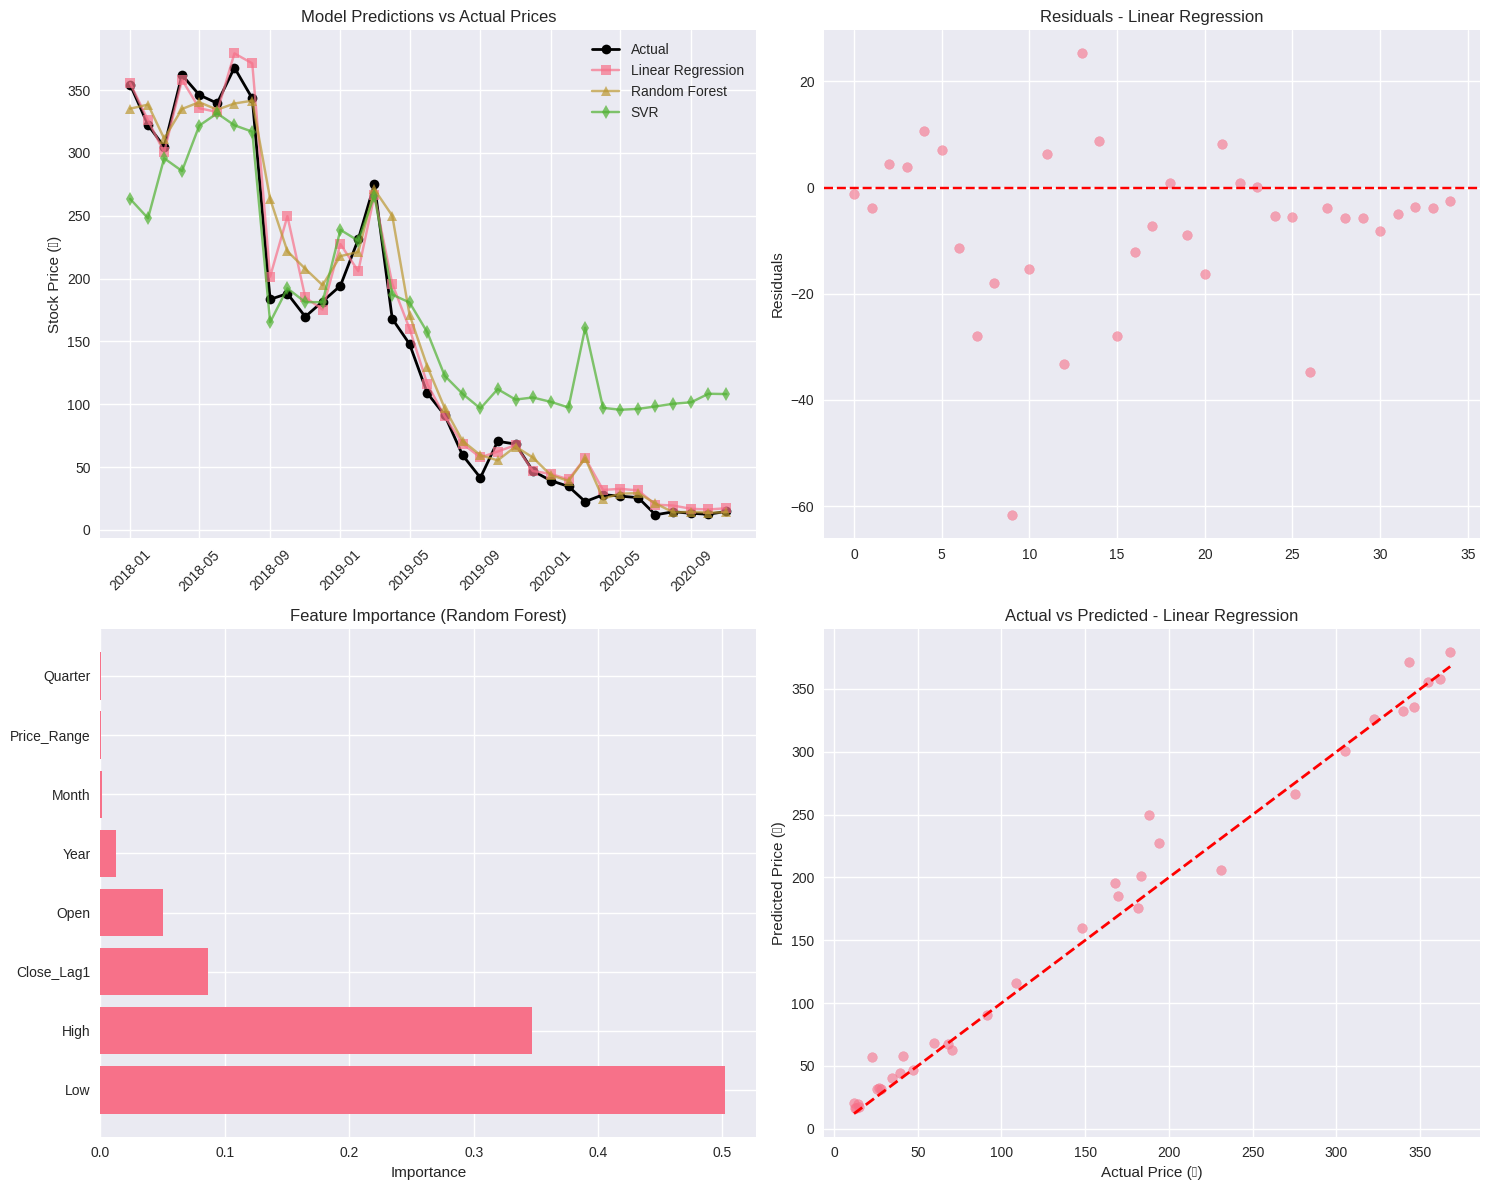

In [133]:
# Create prediction comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Get test dates for plotting
test_dates = df_clean.iloc[X_test.index]['Date']

# Plot 1: Actual vs Predicted (All Models)
axes[0, 0].plot(test_dates, y_test.values, 'o-', label='Actual', color='black', linewidth=2)
axes[0, 0].plot(test_dates, y_pred_lr, 's-', label='Linear Regression', alpha=0.7)
axes[0, 0].plot(test_dates, y_pred_rf, '^-', label='Random Forest', alpha=0.7)
axes[0, 0].plot(test_dates, y_pred_svr, 'd-', label='SVR', alpha=0.7)
axes[0, 0].set_title('Model Predictions vs Actual Prices')
axes[0, 0].set_ylabel('Stock Price (₹)')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Shows how each model's predictions match actual stock prices.
# Random Forest follows the real prices more closely than others.
# Helps compare model performance over time visually.

######################################################################################


# Plot 2: Residuals for best model
if best_model == 'Linear Regression':
    residuals = y_test - y_pred_lr
elif best_model == 'Random Forest':
    residuals = y_test - y_pred_rf
else:
    residuals = y_test - y_pred_svr

axes[0, 1].scatter(range(len(residuals)), residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title(f'Residuals - {best_model}')
axes[0, 1].set_ylabel('Residuals')

# Residuals show the errors between predicted and actual values.
# Points should be scattered around the red line (zero error).
# Helps check if the model is unbiased and consistent.


#####################################################################################

# Plot 3: Feature importance (Random Forest)
top_features = feature_importance_rf.head(10)
axes[1, 0].barh(top_features['feature'], top_features['importance'])
axes[1, 0].set_title('Feature Importance (Random Forest)')
axes[1, 0].set_xlabel('Importance')

# Displays which features the Random Forest used the most.
# 'Low' and 'High' prices had the biggest impact on predictions.
# Helps in selecting important features for future models.


#####################################################################################

# Plot 4: Prediction accuracy scatter
if best_model == 'Random Forest':
    best_predictions = y_pred_rf
elif best_model == 'SVR':
    best_predictions = y_pred_svr
else:
    best_predictions = y_pred_lr

axes[1, 1].scatter(y_test, best_predictions, alpha=0.6)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Price (₹)')
axes[1, 1].set_ylabel('Predicted Price (₹)')
axes[1, 1].set_title(f'Actual vs Predicted - {best_model}')

# Compares actual prices with predicted ones for the best model.
# Dots close to the red line mean better accuracy.
# Shows how well the model performs overall.


plt.tight_layout()
plt.show()

In [134]:

!git config --global user.email "nankikaurarora@gmail.com"
!git config --global user.name "Nanki Kaur Arora"

!git clone https://github.com/nanki-kaur/YesBank-stockprediction


Cloning into 'YesBank-stockprediction'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [136]:
# Save the current notebook (if you're inside it)
from google.colab import drive
import os

# Change working directory to your GitHub repo
%cd /content/YesBank-stockprediction

# Save the notebook here manually via File > Save a copy in Drive


/content/YesBank-stockprediction
